# Large-scale Content-Based Image Retrieval
---

While we introduce the problem, let's download the data we will use throughout this session. *Note:* only do this if you did not do it prior to starting this notebook.

In [ ]:
!python download.py

## 1. Introduction

#### 1.1 The image retrieval problem
<img src="images/CBIR.png" height="10" width="400" align="right">


Content-based image retrieval (CBIR) is the process of searching for images in a large database, given a visual query for search. Technically, there are three key components in CBIR:  
  1. Image representation
  2. Database organisation
  3. Image distance measurement



We can further specify the definition of CBIR above.

> CIBR makes use of the ***representation*** of visual content to identify relevant images in a database.


<u>In this lesson we will focus on a **Query-based Image Retrieval** problem, which uses an example image as query.</u>
<br>

> At the end of this session, we expect to be able to have a function as below.  
As we go through the notebook we will learn all the ingredients to implement such function.

In [ ]:
def retrieve(database, query):
    raise NotImplemented

#### 1.2 CBIR pipeline
We can distinguish two main stages in a CBIR framework: an **offline** stage, and an **online** stage [ref].  

<div style="img {align: left}">
<img src="images/pipeline.png">
<em>Add image caption with reference</em>
</div>

The objective of the **offline** stage is to use the image stack to build an indexed database. We tend to concentrate the computational effort in this stage of creation, to ease, instead, the online stage.
It is concerned with two main operations:
- Create a representation of the images
- Efficiently index the images 



Given a *query* image, the objective of the **online** stage is to score part (or all) of the images in the database, and return the ones with the higest scores.



This is how we would implement a CBIR model.  
We will divide the CBIR into different functionalities and address each functional block as we go through the notebook. In the last part of the session, we will put everything together.

In [ ]:
class CBIR:
    def __init__(self, dataset):
        self.dataset = dataset
        self.database = None  # we haven't built an indexed database yet
        return
    
    #-- TASK 1
    def find_keypoints(self, image):
        # Implement me using MSER, please
        raise NotImplemented
        
    #-- TASK 2
    def extract_features(self, image):
        # Implement me using SIFT, please
        raise NotImplemented
    
    #-- TASK 3
    def create_vocabulary(self, image):
        # Implement me using extract_features and BOW, please
        raise NotImplemented

    #-- TASK 4
    def encode(self, dataset):
        # Implement me using vocabulary tree, please
        raise NotImplemented
    
    #-- TASK 5
    def score(self, image):
        raise NotImplemented
    
    #-- TASK 6
    def retrieve(self, query):
        # this is the function we have described above
        raise NotImplemented


## 2. Offline stage: building the database

**2.1 Find keypoints**

<div style="margin:auto; float:right; margin-left: 50px; width: 45%">
<img src="images/features_extraction_only.jpeg">
<em>Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference</em>
</div>

<p style="color: #a00; font-weight: 700">>> TASK 1</p>

> In this section we are going to learn how to implement the function:
```python
def find_keypoints(self, image):
    raise features
```
which extract a set of keypoints later used to describe the image.

Keypoints can be thought of as **landmarks** in a scene. Similar to the intuitive "human" notion of landmarks, keypoints are distinctive locations in space. Unlike what humans treat as a landmark, they can be computed
directly from image data, based on the principle that landmarks should be relatively sparse, distinctive, and stable. Once landmarks have been found, they can be used as reference points around which to build descriptions of surrounding image structure.

We will implement feature extraction using the [Scale Invariant Feature Transform (SIFT)](https://link.springer.com/content/pdf/10.1023/B:VISI.0000029664.99615.94.pdf) method. SIFT is an image descriptor for image-based matching and recognition developed by David Lowe (1999, 2004). This descriptor, as well as related image descriptors, are used for a large number of purposes in computer vision for point matching between different views of a 3-D scene, and view-based object recognition. The SIFT descriptor is approximately invariant to translations, rotations and scaling transformations in the image domain and robust to moderate perspective transformations and illumination variations.[ref]

**2.2 Manipulating images**

To perform fast manipulations on the images, we will use the [open-cv library](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html). We start by importing it, together with the `numpy` library and the `matplotlib` library for image plotting:

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

We now call some functions that take care of handling our image dataset, manipulating and showing our images, and showing the landmark points that we are going to detect.

In [2]:
from support_functions import Dataset, show_corners_on_image, show_image

# Loading the dataset
dataset = Dataset()

Let's look at a random image from the dataset:

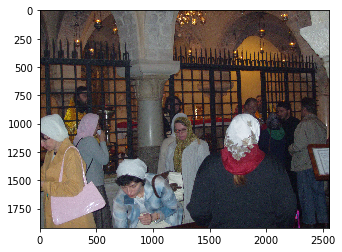

In [3]:
img = dataset.get_random_image()
show_image(img)

### Corner detector 

A possible set of interesting points is given by the corners of the objects in the image. We will now implement the Corner detector operator developed by [Harris and Stephens](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html), to extract them from the image.

##### Derivation of the algorithm

[Can add some math here, but I think it gets too long..]

##### Implementation

The idea boils down to the following steps:

1. We estimate the two gradient images $I_x$ and $I_y$ using [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator) on the original image.


2. Using them, we build a score function which, for each pixel, returns the likelihood of it being a corner

$$
R = g(I^2_x)g(I^2_y) - g(I_xI_y)^2 - \alpha\left[g(I_x)+g(I_y)\right]^2
$$

where $g(\cdot)$ is a blurring operator obtained by filtering with a gaussian kernel of size $\sigma$. The formulas comes from [considerations about the image local variation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html). 

3. Find the regions of this function above a given treshold $k$. That means, we consider as corner all the pixels for which $R > k$. The last inequality defines the binary map of the corners

Both the Sobel and blurring operators are computed in a similar fashion.

**could remove this if too much math, given the tutorial time **
** ---------------------------------**

For the Sobel operators, we convolve the image with the following kernels:

$$
I_x = \begin{bmatrix}
+1 & 0 & -1\\ 
+2 & 0 & -1\\ 
+1 & 0 & -1
\end{bmatrix} * I \qquad \text{ and } \qquad
I_y = \begin{bmatrix}
+1 & +2 & +1\\ 
0& 0 & 0\\ 
-1 & +2 & -1
\end{bmatrix} * I,
$$

while for the blurring operator we use a gaussian kernel.

** ---------------------------------**

Let's start by loading an image with well defined corners. We will load it in grayscale

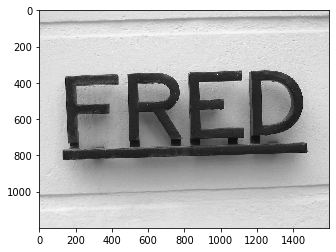

In [4]:
# Loading and displaying an image
img = dataset.get_image_by_name('110901.jpg', gray=True)
show_image(img, gray=True)

To estimate the spatial derivative, we use the function `cv2.Sobel()`. The function accepts the following parameters

```txt
# The first 4 parameters are mandatory
cv2.Sobel(src, ddepth, dx, dy, dst, ksize, scale, delta, borderType):

    # Parameters 
    src – input image.
    ddepth – output image depth (precision).
    dx – order of the derivative x.
    dy – order of the derivative y.
    ksize – size of the extended Sobel kernel
```
For more details on how to call this function you can check the [documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=sobel#sobel) (keeping in mind that such documentation is shared between different programming languages).

Let's calculate the horizontal derivative of the image $I_x$

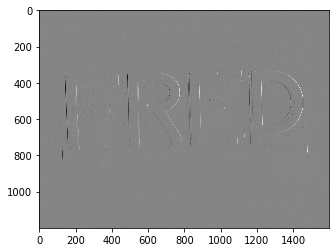

In [5]:
Ix = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
show_image(Ix, gray=True)

We can also freely manipulate the image using `numpy`. As an example, in the next cells we evaluate $\sin \left( \frac{I}{10} \right) > 0 $ and $0.1g\left(I_y\right) + I$ using a [gaussian blur function](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html#gaussian-filtering). You are encouraged to play with different images and functions.

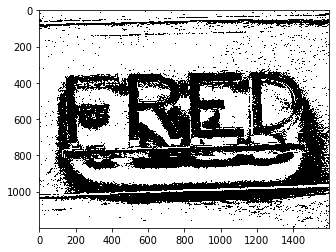

In [6]:
z = np.sin(img/10) > 0
show_image(z, gray=True)

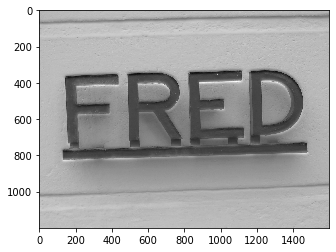

In [7]:
Iy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
g_Iy = cv2.GaussianBlur(Iy,(45,45),0)
show_image(0.1*g_Iy + img, gray=True)

__TASK__

You should implement the missing parts of the following function in order to calculate the score $R$, which is given by the fomula

$$
R = g(I^2_x)g(I^2_y) - g(I_xI_y)^2 - \alpha\left[g(I_x)+g(I_y)\right]^2
$$

This will complete the implementation of the Corner keypoint detector. You can check you results by running the following two cells:

In [8]:
def find_keypoints(img):
    ## Harris corner detector
    
    # Parameters
    gaussian_kernel_size = 15
    alpha = 0.1
    k = 0.05
    
    # Evaluation
    Ix = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    Iy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

    
    gIx2 = cv2.GaussianBlur(Ix**2,(gaussian_kernel_size,gaussian_kernel_size),0)
    
    ####### TO DO BY STUDENT ########
    Iy2 = cv2.GaussianBlur(Iy**2,(gaussian_kernel_size,gaussian_kernel_size),0)

    sq = gIx2*Iy2
                              
    mix = cv2.GaussianBlur(Ix*Iy,(gaussian_kernel_size,gaussian_kernel_size),0)**2
    sumgrad = cv2.add(
        cv2.GaussianBlur(Ix,(gaussian_kernel_size,gaussian_kernel_size),0),
        cv2.GaussianBlur(Iy,(gaussian_kernel_size,gaussian_kernel_size),0)
    )
    sumgrad2 = cv2.multiply(sumgrad,sumgrad)
    R = sq - mix - alpha*sumgrad2
    
    ##################################
            
    binary_map_of_corners = R > k*R.max()
    return binary_map_of_corners

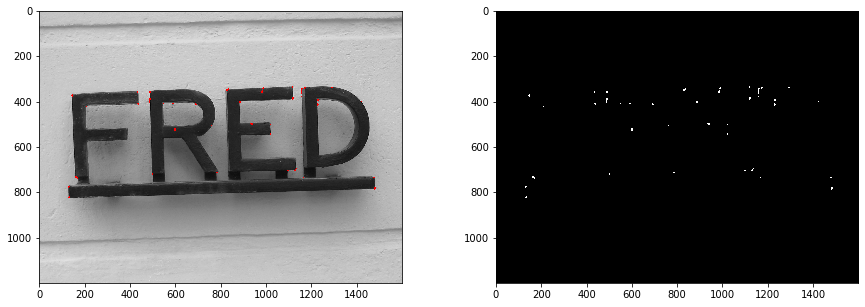

In [9]:
img = dataset.get_image_by_name('110901.jpg', gray=True)
keypoints = find_keypoints(img)

plt.figure(figsize=(15,5))
plt.subplot(121)
show_corners_on_image(img,keypoints)
plt.subplot(122)
show_image(keypoints, gray=True)

Let's compare our implementation with the one from opencv. You can try to tune the parameters of the function to improve your corner detection. You are also invited to experiment with different pitcures

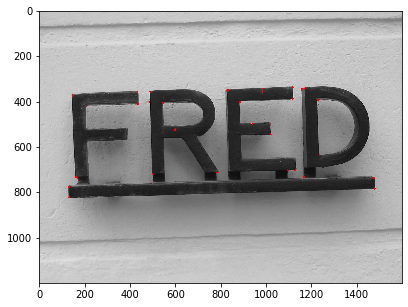

In [10]:
# Compare to OpenCV implementation   
dst = cv2.cornerHarris(img,4,21,0.01)
dst = cv2.dilate(dst,None)
dst = dst>0.05*dst.max()

plt.figure(figsize=(7,5))
show_corners_on_image(img,dst)

#### Better keypoints

Clearly, corners are not the only interesting locations of an image. One could argue that probably the letters FRED are much more distinctive signs of this image, which calls for more general and sofisticate keypoints detectors.

To build our database, we will use the [Maximally stable extremal region extractor (MSER)](https://docs.opencv.org/3.4/d3/d28/classcv_1_1MSER.html), which possesses a lot of invariances such as for scaling, rotations, photometric transformations etc.

The following code sets up a MSER detector function which you can test on different images. Now one could use this function on the entire dataset, building a list of interesting keypoints for each image.

__(I dont think they should code any of this)__

In [11]:
from support_functions import detect_MSER_blobs, show_MSER_blobs

Let's try it on `FRED`

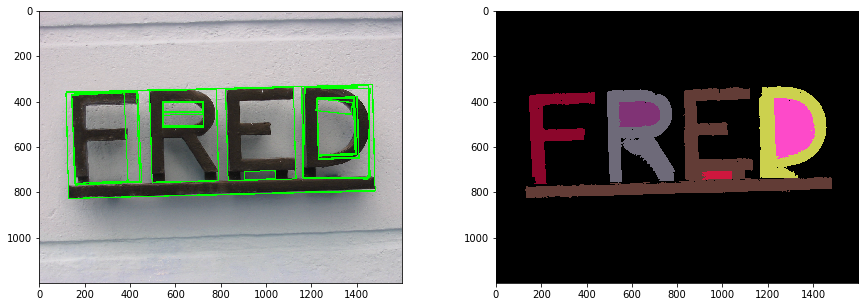

In [12]:
img = dataset.get_image_by_name('110901.jpg', gray=False)
blobs = detect_MSER_blobs(img)

plt.figure(figsize=(15,5))
show_MSER_blobs(img, blobs)

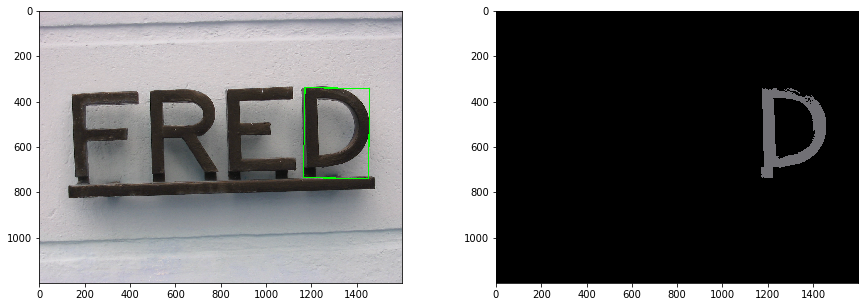

In [13]:
# Example of a single keypoint
plt.figure(figsize=(15,5))
show_MSER_blobs(img, blobs[0:1])

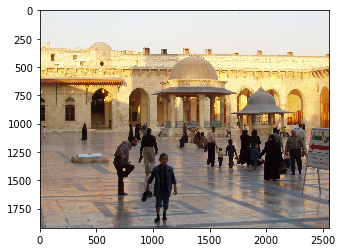

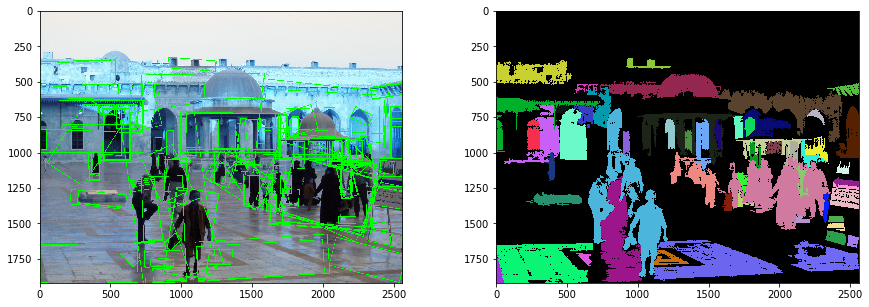

In [26]:
# Try on a random image of the dataset
img = dataset.get_random_image(gray=False)
blobs = detect_MSER_blobs(img)

show_image(img, gray=False)

plt.figure(figsize=(15,5))
show_MSER_blobs(img, blobs)
plt.show()


<div style="margin: auto; float: left; margin-right: 50px; width: 19%">
<img src="images/bow.png">
<em>Add image caption with reference</em>
</div>

**2.2 Image representation**  

On the other hand, we will implement the "Bag of visual words" model [ref]. It borrows the "bag of words" concept from the natural language processing field, and implements a visual surrogate.

<div style="margin-left: 230px">
<br>
    
    
<p style="color: #a00; font-weight: 700">>> TASK 2</p>
    
> In this section we are going to learn how to implement the function:
```python
def extract_descriptors(self, image):
    return embedding
```
</div>

In CBIR an image is transformed to some kind of feature space. The motivation is to achieve an implicit alignment so as to eliminate the impact of background and potential transformations or changes while keeping the intrinsic visual content distinguishable. [ref]


Once we have obtained the features of an image, ee will implement the "Bag of visual words" model [ref]. It borrows the cocept of "bag of words" from the natural language processing field, and implements its visual correspondent.

In [ ]:
def extract_descriptors(self, image):
    # SIFT
    raise NotImplemented

#### 1.3. Creating a visual vocabulary

<div style="margin:auto; float:right; margin-left: 50px; width: 30%">
<img src="images/vocabulary_tree.png">
<em>Add image caption with reference</em>
</div>
<br>
    
<p style="color: #a00; font-weight: 700">>> TASK 3</p>

> In this section we are going to learn how to implement the function:
```python
def create_vocabulary(dataset):
    return indexed_database
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses inverted indices and hierarchical k-means to build the graph.

In [ ]:
def create_vocabulary(dictionary_of_features):
    # Hierarchical k-means
    raise NotImplemented

#### 1.3. Mapping image data using the vocabulary

<div style="margin:auto; float:right; margin-left: 50px; width: 30%">
<!-- <img src="images/vocabulary_tree.png"> -->
<!-- <em>Add image caption with reference</em> -->
</div>
<br>
    
<p style="color: #a00; font-weight: 700">>> TASK 4</p>

> In this section we are going to learn how to implement the function:
```python
def encode(dataset):
    return indexed_database
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses inverted indices and hierarchical k-means to build the graph.

## 2. Online stage: get the _n_ most similar instances from a query image

**2.1 Image Scoring**  
<!-- <div style="margin-left: 230px"> -->
<br>


<p style="color: #a00; font-weight: 700">>> TASK 5</p>

> In this section we are going to learn how to implement the function:
```python
def score(database, image):
    return score
```
<!-- </div> -->


In [ ]:
# We add some code here

**2.2 Reindexing**

Maybe this is not necessary *AAB: Agree - delete; I will discuss the pain of reindexing in lecture*

In [ ]:
# We add some code here

## 3. Complete CBIR model
Here we bring together all the concepts we have illustrated above to build our Large-Scale CBIR system.

In [ ]:
# We add some code here

## 4. [Optional] Features extraction with Deep Convolutional Neural Networks
The excercises below this point are not mandatory. They provide a wider picture on how to build an efficient image representation. We will illustrate two techniques that will require elements of Deep Learning:
- 4.1 Using pretrained deep artificial neural networks to build a representation of the image
- 4.2 Fine tune a pretrained model on our database

**4.1 Using a pre-trained network**

We can either:
- Illustrate http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf and use denoising autoencoders,
- Or go more basic and use a DCNN (https://arxiv.org/abs/1404.1777)

Regardless, I think that the best option is to use a pre-trained network - ResNet50?.  

We can add also another step, if we have the time and people have the will, in wich we fine tune the network (only last layer?) on our database

In [ ]:
# we add some code here

**4.2 Fine-tuning a pre-trained network**

In [ ]:
# We add some code here

In [ ]:
from IPython.display import Markdown as md
md(open("README.md", "r").read())